In [1]:
import pandas as pd
import numpy as np

import mne
from mne.time_frequency import psd_welch

import helper as helper #custom

# visualization stuff
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# 1. Import Data

In [2]:
df = pd.read_csv('data/ssvep-20trials-3s-chaky-bigsquare.csv')

In [3]:
df.shape #check the size of 0

(62436, 10)

In [4]:
print(df[df.Marker==2].shape) #10hz
print(df[df.Marker==1].shape) #6hz
#df.loc[df.Marker==3].index
#df = df.drop(df.loc[df.Marker == 3].index)
print(df[df.Marker==3].shape) #15hz

(20, 10)
(20, 10)
(20, 10)


df.rename(columns={'Unnamed: 1':'Fp1',
                          'Unnamed: 2':'Fp2',
                          'Unnamed: 3':'F3',
                          'Unnamed: 4':'F4'}, 
                 inplace=True)

In [5]:
df.rename(columns={'Unnamed: 1':'O1',
                          'Unnamed: 2':'Oz',
                          'Unnamed: 3':'O2'
                      }, 
                 inplace=True)

In [6]:
df.head()

,timestamps,O1,Oz,O2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Marker
0,62389.150,38956.250,27233.611,44154.887,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
1,62389.150,39004.645,27278.182,44197.668,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
2,62389.151,39005.805,27278.383,44199.301,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
3,62389.152,38978.270,27251.068,44177.395,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
4,62389.152,38944.137,27219.082,44149.145,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0


In [7]:
df = df.drop(["timestamps", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"], axis=1)

df = df.drop(["timestamps"], axis=1)

In [8]:
df.head()

,O1,Oz,O2,Marker
0,38956.250,27233.611,44154.887,0
1,39004.645,27278.182,44197.668,0
2,39005.805,27278.383,44199.301,0
3,38978.270,27251.068,44177.395,0
4,38944.137,27219.082,44149.145,0


# 2. Transform Data into Raw MNE object

Creating RawArray with float64 data, n_channels=4, n_times=62436
    Range : 0 ... 62435 =      0.000 ...   249.740 secs
Ready.
Effective window size : 8.192 (s)


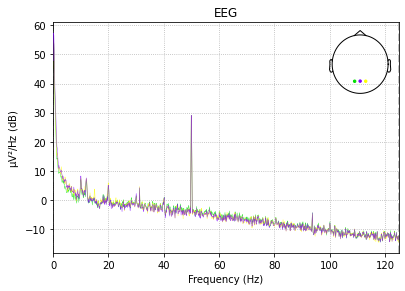

In [9]:
raw = helper.df_to_raw(df)

# 3. Preprocessing

## Notch Filter

Some artifacts are restricted to certain frequencies and can therefore be fixed by filtering. An artifact that typically affects only some frequencies is due to the power line.

Power-line noise is a noise created by the electrical network. It is composed of sharp peaks at 50Hz (or 60Hz depending on your geographical location). Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz, … (or 120Hz, 180Hz, …).

Remove the 50Hz power line noise in Thailand.  We will also be remove its harmonics, i.e., 100Hz, 150Hz, etc.  Since our signal is 125Hz (250Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 125 Hz.

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Effective window size : 8.192 (s)


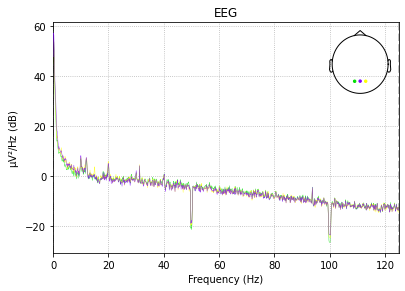

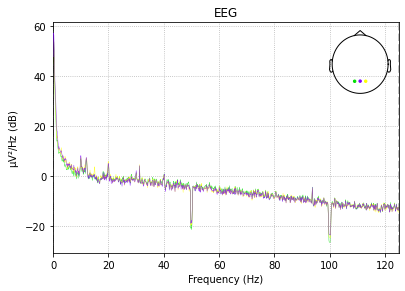

In [10]:
raw.notch_filter(np.arange(50, 125, 50), filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem
#observe that the 50Hz noise is now gone, yay!
raw.plot_psd()

## Band pass filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 17 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 17.00 Hz: -6.02, -6.02 dB

Effective window size : 8.192 (s)


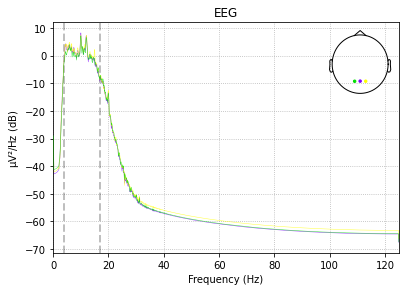

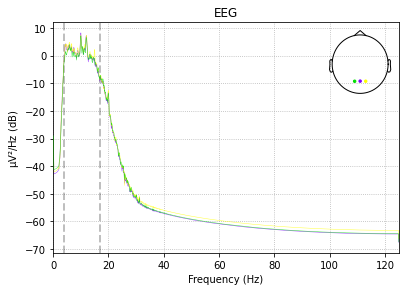

In [11]:
#according to https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0077536,
#the optimal range is 12-18hz

#since we use 6hz, 10hz, and 15hz, 
#we will take three harmonics, which maximum freq is 15 x 3 = 45
#we will take +- 2 at each end, thus 6-4 = 2, and 45+2 = 47

raw.filter(4, 50, method='iir')

raw.plot_psd()

## Independent component analysis

SSVEP is not sensitive against eye artifacts

# 3. Epoching

In [12]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'6Hz': 1, '10Hz' : 2, '15Hz' : 3}
tmin=-0.5
tmax=3
epochs = helper.getEpochs(raw, event_id, tmin, tmax)
#print(epochs.get_data())

60 events found
Event IDs: [1 2 3]
sample drop %:  0.0


## Stimuli-Specific PSD

Effective window size : 4.112 (s)
Effective window size : 4.112 (s)
Effective window size : 4.112 (s)


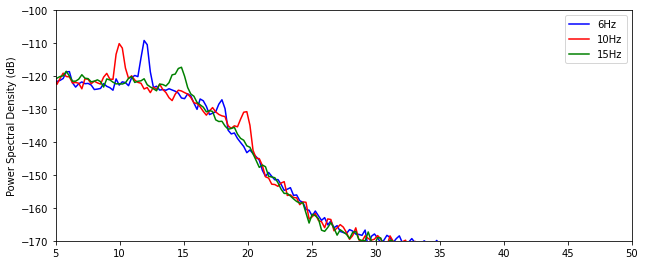

In [13]:
fig = plt.figure(figsize=(10, 4))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

psd1, freq1 = psd_welch(epochs['6Hz'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['10Hz'], n_fft=1028, n_per_seg=256 * 3)
psd3, freq3 = psd_welch(epochs['15Hz'], n_fft=1028, n_per_seg=256 * 3)

logpsd1 = 10 * np.log10(psd1)
logpsd2 = 10 * np.log10(psd2)
logpsd3 = 10 * np.log10(psd3)

log_psd1_mean = logpsd1.mean(0)
log_psd1_std = logpsd1.mean(0)

log_psd2_mean = logpsd2.mean(0)
log_psd2_std = logpsd2.mean(0)

log_psd3_mean = logpsd3.mean(0)
log_psd3_std = logpsd3.mean(0)

axes.plot(freq1, log_psd1_mean[[0,2], :].mean(0), color='b', label='6Hz')
axes.plot(freq2, log_psd2_mean[[0,2], :].mean(0), color='r', label='10Hz')
axes.plot(freq2, log_psd3_mean[[0,2], :].mean(0), color='g', label='15Hz')

axes.set_title('')
axes.set_ylabel('Power Spectral Density (dB)')
axes.set_xlim(5, 50)
axes.set_ylim(-170, -100)
axes.legend()

# Filterbank CCA

In [14]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/chaklam/bci_project/BCI/SSVEP/utils')

from fbcca import fbcca
from filterbank import filterbank

epochs.pick_types(eeg=True)
X1 = epochs['6Hz'].get_data()
X2 = epochs['10Hz'].get_data()
X3 = epochs['15Hz'].get_data()
list_freqs = [6, 10, 15]
fs = 250
num_harms = 5
num_fbs = 5

print("6hz: =======")
fbcca(X1, list_freqs, fs, num_harms, num_fbs)
print("10hz: =======")
fbcca(X2, list_freqs, fs, num_harms, num_fbs)
print("15hz: =======")
fbcca(X3, list_freqs, fs, num_harms, num_fbs)



6hz: =======
rho:  [1.59205236 0.5300834  0.44945986]
result:  0
correlation:  1.5920523587224822
10hz: =======
rho:  [0.93056343 1.45437946 0.70290659]
result:  1
correlation:  1.4543794604689908
15hz: =======
rho:  [0.98989412 0.85970828 1.33805407]
result:  2
correlation:  1.3380540697664047
